In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import os

from sklearn import tree
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


import warnings
warnings.filterwarnings("ignore")

# Random Forests

A continuación vamos a ver uno de los algoritmos de clasificación/regresión más populares, que sin ser de los más avanzados, como redes neuronales/xgboost, permite buenos resultados, basados en la aleatorización de árboles de decisión binarios, tanto por filas (registros) como por columnas (variables). El conjunto de árboles, llamado bosque, permite un poder predictivo muy alto a la vez que evita el sobreajuste.

<div>
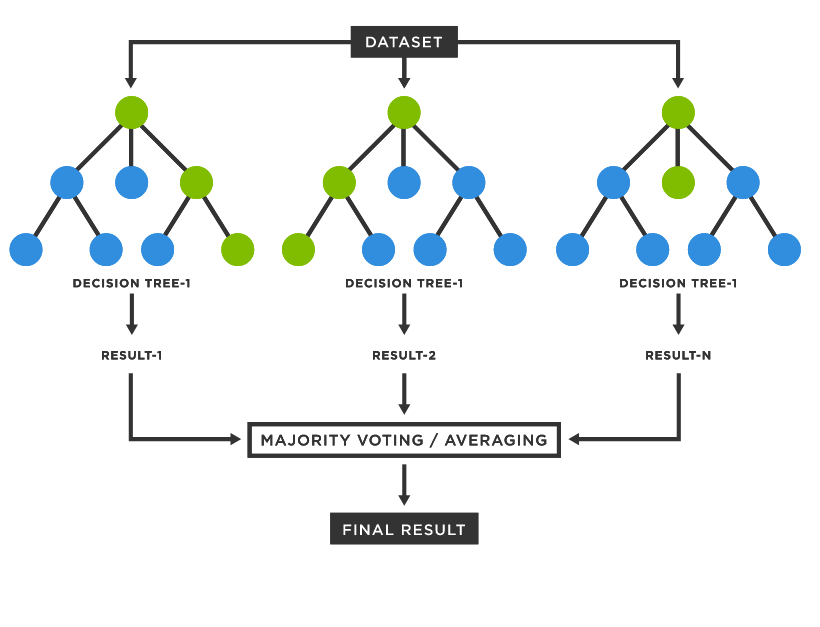
</div>

In [ ]:
dfcomplete = pd.read_csv("../data/2008_small.zip", nrows = 200000)

dfcomplete = dfcomplete.dropna(subset = ['AirTime','Distance','TaxiIn','TaxiOut',"DepDelay","ArrDelay"])
df = dfcomplete.sample(frac=1).head(30000)

X = df[['AirTime','Distance','TaxiIn','TaxiOut',"DepDelay"]]
Y = df["ArrDelay"] > 0

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2, random_state=1)

np.mean(y_test) # 43.33 % vuelos tarde // 56.67 % vuelos pronto

#### Caso sencillo. Árbol de clasificación
Un solo árbol, determinista para hacer la predicción

In [ ]:
clf = tree.DecisionTreeClassifier()
clf.fit(X_train,y_train)
predictions = clf.predict(X_test)
np.mean(predictions == y_test)

#### Random forest

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [ ]:
clf = RandomForestClassifier(n_estimators=1000, max_depth = None, n_jobs= -1)
clf.fit(X_train,y_train)
predictions = clf.predict(X_test)
np.mean(predictions == y_test)

>Clasificar la importancia de las variables

In [ ]:
X.columns

In [ ]:
clf.feature_importances_

In [ ]:
clf.feature_importances_.sum()

>Ranking de variables

In [ ]:
X.columns[np.argsort(-clf.feature_importances_)]

In [ ]:
pd.DataFrame({"Col":X.columns,"Imp":clf.feature_importances_}).sort_values("Imp", ascending = False)

In [ ]:
clf.predict_proba(X_test).round(3)

### Ajuste automático del random forest

Una optimización de parámetros más eficiente que en los ejemplos anteriores

**GridSearchCV**\
realiza un ajuste de hiperparámetros para determinar los valores óptimos para un modelo determinado. 
Hay que tener en cuenta que no hay forma de saber de antemano los mejores valores para los hiperparámetros, por lo que, idealmente, debemos probar todos los valores posibles para conocer los valores óptimos. Hacer esto manualmente podría requerir una cantidad considerable de tiempo y recursos y, por lo tanto, usamos GridSearchCV para automatizar el ajuste de los hiperparámetros.

In [ ]:
# EJECUTAR MEJOR SIN n_estimators = 200 y max_depth = 50
parameters = {'bootstrap':(True,False), 
              'n_estimators':[50,200, 500],
              'max_depth':[5,10,20,None], 
              'max_features':[1,3] #Más útil con datasets grandes
             }

clf = RandomForestClassifier(n_jobs= -1)
clfcv = GridSearchCV(clf, parameters,verbose=3,scoring = "accuracy")
# https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
clfcv.fit(X, Y)

In [ ]:
clfcv.cv_results_

In [ ]:
clfcv.best_params_

>Ajustar el mejor modelo, con todos los datos:

In [ ]:
X = dfcomplete[['AirTime','Distance','TaxiIn','TaxiOut',"DepDelay"]]
Y = dfcomplete["ArrDelay"] > 0

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2)


clf = RandomForestClassifier(n_estimators = clfcv.best_params_["n_estimators"], 
                             bootstrap = clfcv.best_params_["bootstrap"], 
                             max_depth = clfcv.best_params_["max_depth"], 
                             max_features= clfcv.best_params_["max_features"],
                             n_jobs = -1)

clf.fit(X_train,y_train)
predictions = clf.predict(X_test)
np.mean(predictions == y_test)

>Ahora estoy convencido que el modelo funciona.

#### Exportar un modelo al disco

In [ ]:
# Entrenar con TODOS los datos

clf = RandomForestClassifier(n_estimators = clfcv.best_params_["n_estimators"], 
                             bootstrap = clfcv.best_params_["bootstrap"], 
                             max_depth = clfcv.best_params_["max_depth"],
                             max_features= clfcv.best_params_["max_features"],
                             n_jobs = -1)

clf.fit(X,Y)

# Guardar el modelo en disco
filename = 'mirandomforest.sav'
pickle.dump(clf, open(filename, 'wb'))
 
print("Modelo Guardado")

del(clf)
    
print("Modelo Borrado del Jupyter Notebook")

#### Cargar el modelo
Y lo usamos con nuevos datos que entramos directamente

In [ ]:
modelo = pickle.load(open('mirandomforest.sav', 'rb'))

>Crearemos un objeto vacío aprovechando el objeto X

#### Opción 1. Input

In [ ]:
newflight = pd.DataFrame(columns=X.columns, index=range(1))
newflight

In [ ]:
newflight = pd.DataFrame(columns=['AirTime','Distance','TaxiIn','TaxiOut',"DepDelay"], index=range(1))

newflight["AirTime"] = int(input("Airtime"))
newflight["Distance"] = int(input("Distance"))
newflight["TaxiIn"] = int(input("TaxiIn"))
newflight["TaxiOut"] = int(input("TaxiOut"))
newflight["DepDelay"] = int(input("DepDelay"))

print("Prediccion:",modelo.predict_proba(newflight)[0])

#### Opción 2. GUI

In [ ]:
# ! pip install tk

In [ ]:
from tkinter import *
from tkinter.ttk import *
from tkinter import messagebox

In [ ]:
def validate():
    global t, d, ti, to, r
    
    newflight = pd.DataFrame(columns=['AirTime','Distance','TaxiIn','TaxiOut',"DepDelay"], index=range(1))

    t, d, ti, to, r = tiempo_value.get(), distancia_value.get(), taxiin_value.get(), taxiout_value.get(), retraso_value.get()
    newflight["AirTime"] = int(t)
    newflight["Distance"] = int(d)
    newflight["TaxiIn"] = int(ti)
    newflight["TaxiOut"] = int(to)
    newflight["DepDelay"] = int(r)
    
    print("prediccion",modelo.predict(newflight)[0])
    
    if modelo.predict(newflight)[0]:
        messagebox.showinfo("PREDICCION","Vuelo con retraso esperado")
    else:
        messagebox.showinfo("PREDICCION","Vuelo sin retraso esperado")

    return ""

In [ ]:
window = Tk()

window.title("RandomForest")
window.geometry('350x700')

tiempo = Label(window, text="Tiempo de vuelo",font=("Arial Bold", 30))
tiempo.grid(column=0, row=6)

tiempo_value = Entry(window,width=30)
tiempo_value.grid(column=0, row=7,pady=5)

distancia = Label(window, text="Distancia",font=("Arial Bold", 30))
distancia.grid(column=0, row=8)

distancia_value = Entry(window,width=30)
distancia_value.grid(column=0, row=9,pady=5)


taxiin = Label(window, text="Taxi In",font=("Arial Bold", 30))
taxiin.grid(column=0, row=10)

taxiin_value = Entry(window,width=30)
taxiin_value.grid(column=0, row=11,pady=5)


taxiout = Label(window, text="Taxi Out",font=("Arial Bold", 30))
taxiout.grid(column=0, row=12)

taxiout_value = Entry(window,width=30)
taxiout_value.grid(column=0, row=13,pady=5)

retraso = Label(window, text="Retraso de Salida",font=("Arial Bold", 30))
retraso.grid(column=0, row=14)

retraso_value = Entry(window,width=30)
retraso_value.grid(column=0, row=15,pady=5)

btn = Button(window, text="Predecir",command = validate)
btn.grid(column=0, row=18)

window.mainloop()

# Ejercicios

Explora el dataframe breastCancer.csv, el de cars o el de iris (lo importante aquí es la técnica, no los datos concretos)

https://www.kaggle.com/datasets/nancyalaswad90/breast-cancer-dataset?resource=download&select=data.csv

Añade algunas variables adicionales que puedan servirnos posteriormente. ¿Con qué criterio lo podemos hacer, si desconocemos el campo?

**Ajusta un modelo predictivo para anticipar el diagnóstico.** 

Utiliza una estrategia de validación que te permita estar seguro que estamos haciendo unas buenas predicciones. Prueba primero algunos ejemplos simples de modelos, que te permitan seleccionar cuales pueden funcionar mejor.

Mejora tanto como puedas el modelo, usando varias de las técnicas que hemos trabajado (Transformaciones, ingeniería de variables, gridsearch...)

¿Qué variables son las más útiles para hacer un buen diagnóstico?

Crea una aplicación con GUI que, usando las variables más relevantes, te de una predicción. ¿Qué harías con las menos relevantes?

##### © Netmind S.L.

Todos los derechos reservados. Este documento (v1.00) ha sido diseñado para el uso exclusivo del cliente que atiende a esta formación.

Ninguna parte de este documento puede ser reproducida, distribuida o transmitida en cualquier forma o por cualquier medio sin el permiso previo por escrito de Netmind.